<a href="https://colab.research.google.com/github/SarathiJr45/Machine-Translation/blob/main/Machine_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_sentences(file_path):
  sentences=[]
  with open(file_path,'r',encoding='utf-8') as file:
    for line in file:
      sentence=line.strip()
      if sentence:
        sentences.append(sentence)
    return sentences

def load_bilingual_data(source_lang,target_lang):
  source_sentences=load_sentences(source_lang)
  target_sentences=load_sentences(target_lang)

  assert len(source_sentences)==len(target_sentences),'mismatched no.of sentences'

  alligned_data=list(zip(source_sentences,target_sentences))
  return alligned_data

source_file_path='/content/drive/MyDrive/en-ta.txt/GNOME.en-ta.en'
target_file_path='/content/drive/MyDrive/en-ta.txt/GNOME.en-ta.ta'

bilingual_data=load_bilingual_data(source_file_path,target_file_path)
print(len(bilingual_data))
print(bilingual_data[100])

23997
('Important', 'முக்கியம்')


In [ ]:
#preprocess
import string
import re
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

def preprocess_sentences(sentence):
  sentence=sentence.lower()
  sentence=sentence.translate(str.maketrans('','',string.punctuation))
  sentence=re.sub(r'\d+','',sentence)
  tokens=word_tokenize(sentence)
  return tokens


def preprocess_bilingual_data(bilingual_data):
  preprocessed_data=[]
  for source_sentence,target_sentence in bilingual_data:
    source_tokens=preprocess_sentences(source_sentence)
    target_tokens=preprocess_sentences(target_sentence)
    preprocessed_data.append((source_tokens,target_tokens))
  return preprocessed_data


preprocessed_bilingual_data=preprocess_bilingual_data(bilingual_data)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print( len(preprocessed_bilingual_data))
print(preprocessed_bilingual_data[1000])
print(bilingual_data[1000])

23997
(['six', 'of', 'clubs'], ['க்ளப்ஸின்', 'ஆறு'])
('six of clubs', 'க்ளப்ஸின் ஆறு')


In [ ]:
# Split the preprocessed data into train, validation, and test sets
from sklearn.model_selection import train_test_split
train_size=0.8
train_data,temp_data=train_test_split(preprocessed_bilingual_data,train_size=0.8,random_state=42)
remaining_size=1-train_size
val_data,test_data=train_test_split(temp_data,test_size=0.1/remaining_size,random_state=42)
print(len(train_data))
print(len(val_data))
print(len(test_data))

19197
2399
2401


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def tokenize_data(data):

    source_sentences = [source for source, _ in data]
    target_sentences = [target for _, target in data]

    source_tokenizer = Tokenizer(filters='')
    source_tokenizer.fit_on_texts(source_sentences)
    source_sequences = source_tokenizer.texts_to_sequences(source_sentences)


    target_tokenizer = Tokenizer(filters='')
    target_sentences_with_tokens = ['<start> ' + str(sentence) + ' <end>' for sentence in target_sentences]
    target_tokenizer.fit_on_texts(target_sentences)
    target_word_index = target_tokenizer.word_index


    target_sequences = target_tokenizer.texts_to_sequences(target_sentences)

    return source_tokenizer, target_tokenizer, source_sequences, target_sequences

def pad_data(source_sequences, target_sequences, max_length):
    """
    Pad the sequences to ensure uniform length.
    """
    padded_source_sequences = pad_sequences(source_sequences, maxlen=max_length, padding='post')
    padded_target_sequences = pad_sequences(target_sequences, maxlen=max_length, padding='post')
    return padded_source_sequences, padded_target_sequences


source_tokenizer, target_tokenizer, source_sequences, target_sequences = tokenize_data(train_data)


max_length = 50
padded_source_sequences, padded_target_sequences = pad_data(source_sequences, target_sequences, max_length)


print( padded_source_sequences.shape)
print( padded_target_sequences.shape)


(19197, 50)
(19197, 50)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Attention


def build_model(source_vocab_size, target_vocab_size, max_length):

    encoder_inputs = Input(shape=(max_length,))
    encoder_embedding = Embedding(source_vocab_size, 256, input_length=max_length)(encoder_inputs)
    encoder_outputs, state_h, state_c = LSTM(256, return_sequences=True, return_state=True)(encoder_embedding)
    encoder_states = [state_h, state_c]


    decoder_inputs = Input(shape=(None,))
    decoder_embedding = Embedding(target_vocab_size, 256)(decoder_inputs)
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)


    attention = Attention()
    context_vector = attention([decoder_outputs, encoder_outputs])


    decoder_combined_context = tf.concat([decoder_outputs, context_vector], axis=-1)


    decoder_dense = Dense(target_vocab_size, activation='softmax')
    decoder_outputs = decoder_dense(decoder_combined_context)


    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    return model

source_vocab_size = len(source_tokenizer.word_index) + 1
target_vocab_size = len(target_tokenizer.word_index) + 1


model = build_model(source_vocab_size, target_vocab_size, max_length)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 50, 256)              556544    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, None, 256)            1044224   ['input_2[0][0]']             
                                                                                              

Epoch 1/10
300/300 [==============================] - 33s 91ms/step - loss: 0.6666 - accuracy: 0.9374 - val_loss: 0.5261 - val_accuracy: 0.9422
Epoch 2/10
300/300 [==============================] - 12s 39ms/step - loss: 0.4123 - accuracy: 0.9418 - val_loss: 0.5880 - val_accuracy: 0.9379
Epoch 3/10
300/300 [==============================] - 10s 35ms/step - loss: 0.3670 - accuracy: 0.9433 - val_loss: 0.6360 - val_accuracy: 0.9365
Epoch 4/10
300/300 [==============================] - 10s 35ms/step - loss: 0.3203 - accuracy: 0.9464 - val_loss: 0.6892 - val_accuracy: 0.9359
Epoch 5/10
300/300 [==============================] - 10s 33ms/step - loss: 0.2646 - accuracy: 0.9525 - val_loss: 0.7348 - val_accuracy: 0.9358
Epoch 6/10
300/300 [==============================] - 10s 35ms/step - loss: 0.2076 - accuracy: 0.9615 - val_loss: 0.7837 - val_accuracy: 0.9356
Epoch 7/10
300/300 [==============================] - 10s 33ms/step - loss: 0.1526 - accuracy: 0.9715 - val_loss: 0.8224 - val_accuracy:

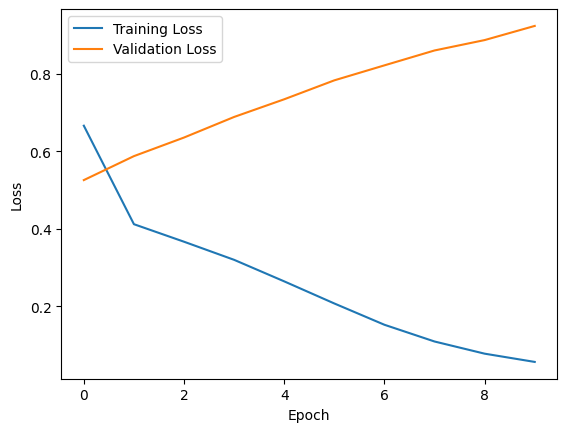

In [ ]:
def tokenize_val_data(data):

    source_sentences = [source for source, _ in data]
    target_sentences = [target for _, target in data]


    source_tokenizer = Tokenizer(filters='')
    source_tokenizer.fit_on_texts(source_sentences)
    source_sequences = source_tokenizer.texts_to_sequences(source_sentences)

    target_tokenizer = Tokenizer(filters='')
    target_tokenizer.fit_on_texts(target_sentences)
    target_sequences = target_tokenizer.texts_to_sequences(target_sentences)

    return source_sequences, target_sequences



train_source_sequences, train_target_sequences = padded_source_sequences, padded_target_sequences


val_source_sequences, val_target_sequences = tokenize_val_data(val_data)
val_padded_source_sequences, val_padded_target_sequences = pad_data(val_source_sequences, val_target_sequences, max_length)

history = model.fit(
    [train_source_sequences, train_target_sequences[:, :-1]],
    train_target_sequences[:, 1:],
    validation_data=([val_padded_source_sequences, val_padded_target_sequences[:, :-1]],
                     val_padded_target_sequences[:, 1:]),
    batch_size=64,
    epochs=10
)


import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:

test_source_sequences, test_target_sequences = tokenize_val_data(test_data)
test_padded_source_sequences, test_padded_target_sequences = pad_data(test_source_sequences, test_target_sequences, max_length)

test_loss, test_accuracy = model.evaluate([test_padded_source_sequences, test_padded_target_sequences[:, :-1]],
                                          test_padded_target_sequences[:, 1:])

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

76/76 [==============================] - 1s 14ms/step - loss: 0.9638 - accuracy: 0.9337
Test Loss: 0.9638099670410156
Test Accuracy: 0.9337350726127625


In [ ]:
def translate_sentence(sentence, source_tokenizer, target_tokenizer, model, max_length):

    sentence = preprocess_sentence(sentence)
    sequence = source_tokenizer.texts_to_sequences([sentence])[0]
    sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
    target_sequence = np.zeros((1, max_length))
    target_sequence[0, 0] = target_tokenizer.word_index['<start>']

    for i in range(max_length):
        if i > 0:
            prediction = model.predict([sequence, target_sequence])
            predicted_index = np.argmax(prediction[0, i - 1, :])
            if predicted_index == target_tokenizer.word_index['<end>']:
                break
            target_sequence[0, i] = predicted_index

    translated_sentence = [target_tokenizer.index_word[int(index)] for index in target_sequence[0] if int(index) != 0]
    translated_sentence = ' '.join(translated_sentence[1:])
    return translated_sentence


source_sentence = "IDistinguished"
translated_sentence = translate_sentence(source_sentence, source_tokenizer, target_tokenizer, model, max_length)
print("Source Sentence:", source_sentence)
print("Translated Sentence:", translated_sentence)


1/1 [==============================] - 0s 20ms/step
Source Sentence: How are you?
Translated Sentence: 
